<a href="https://colab.research.google.com/github/MarihamR/Guided-Projects/blob/main/Object_Localization_with_PyTorch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization 

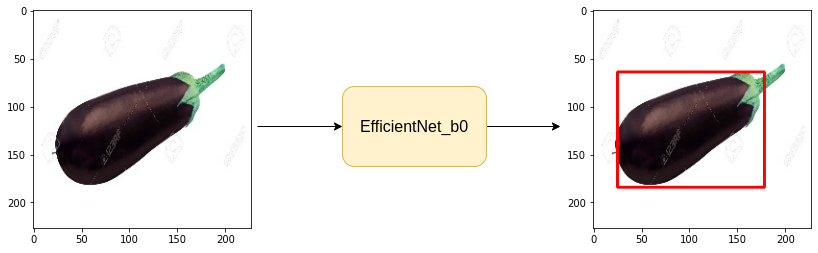

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-4uioetl1
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-4uioetl1
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Download Dataset
!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from torchvision import datasets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
csv_file="/content/object-localization-dataset/train.csv"
dir="/content/object-localization-dataset/"

device="cuda"
batch_size=16
img_size=140
lr=0.001
epochs=40
model="efficientnet_b0"
num_cor=4

In [6]:
df=pd.read_csv(csv_file)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


In [7]:
def get_classes(df):
  labels=df["label"].unique()
  labels
  class_to_indx={}
  indx_to_class={}
  for i in range(3):
    class_to_indx[labels[i]]=i
    indx_to_class[i]=labels[i]
  return class_to_indx,indx_to_class

class_to_indx,indx_to_class=get_classes(df)
indx_to_class

{0: 'mushroom', 1: 'eggplant', 2: 'cucumber'}

# Understand the dataset

In [8]:
row=df.iloc[2]
dir+row.img_path

'/content/object-localization-dataset/train_images/mushroom_20.jpg'

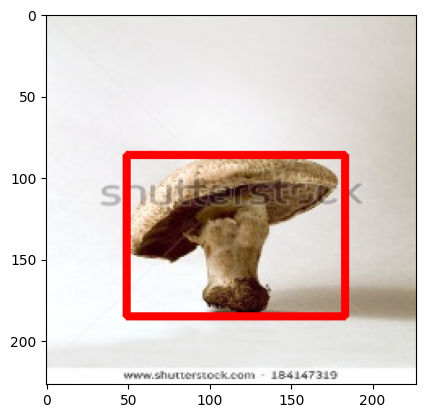

In [9]:
img=cv2.imread(dir+row.img_path)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1=(row.xmin,row.ymin)
pt2=(row.xmax,row.ymax)

bond_box_img=cv2.rectangle(img,pt1,pt2,color=(255,0,0),thickness=3)
plt.imshow(bond_box_img)

In [10]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)
print("Trainset: ", len(train_df) ,"\nValidset: ",len(valid_df))

Trainset:  148 
Validset:  38


# Augmentations

## **Albumentations Library**

In [11]:
import albumentations as A
train_augs=A.Compose(transforms=[
    A.Resize(img_size,img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
    ], bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]) )

valid_augs=A.Compose(transforms=[
    A.Resize(img_size,img_size),
    ], bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]) )

## **Torchvision.Transforms.V2 Library**
### transforms V2 for Object detection and segmentation

In [12]:
from torchvision.transforms import v2 as T
train_trans=T.Compose([
    T.Resize((img_size,img_size)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(30)
    ])

valid_trans=T.Compose([
    T.Resize((img_size,img_size))
    ])

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

# Create Custom Dataset

In [13]:
from torchvision import datapoints
from torchvision.transforms.v2 import functional as F

In [14]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self,df,aug=None,transforms=None):
    self.df=df
    self.aug=aug #Albumenation 
    self.transforms=transforms #torchvision.tranform
    self.class_to_indx,_=get_classes(df)
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self,idx):
    row=self.df.iloc[idx]

    #bounding box
    xmin=row.xmin
    xmax=row.xmax
    ymin=row.ymin
    ymax=row.ymax
    bbox=[[xmin,ymin,xmax,ymax]]

    #labels
    label=self.class_to_indx[row.label]

    if self.aug:
      img=cv2.imread(dir+row.img_path)
      img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      
      data=self.aug(image=img,bboxes=bbox,class_labels=[None])
      img=data["image"]
      bbox=data["bboxes"][0]

    elif self.transforms:
      img=(Image.open(dir+row.img_path)).convert("RGB") 
      bboxes = datapoints.BoundingBox(
          [[xmin,ymin,xmax,ymax]],
          format=datapoints.BoundingBoxFormat.XYXY,
          spatial_size=F.get_spatial_size(img))
      
      img, bbox, label = self.transforms(img, bboxes, label)
      #img = self.transforms(img)
      img = np.asarray(img)
    
    else:
      img=cv2.imread(dir+row.img_path)
      img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)       
    

    img=torch.from_numpy(img).permute(2,0,1)/255.0
    bbox=torch.Tensor(bbox)

    return img,bbox,label

### 1. No Transforms

torch.Size([3, 227, 227])


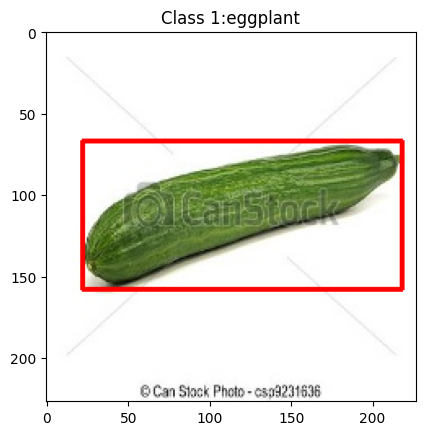

In [15]:
trainset=ObjLocDataset(train_df)
validset=ObjLocDataset(valid_df)

img, bbox,lbl = trainset[12]

xmin, ymin, xmax, ymax = bbox[0]

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)
plt.title(f"Class {lbl}:{indx_to_class[lbl]}")
print(img.shape)

### 2. TorchVision transforms V2

torch.Size([3, 140, 140])


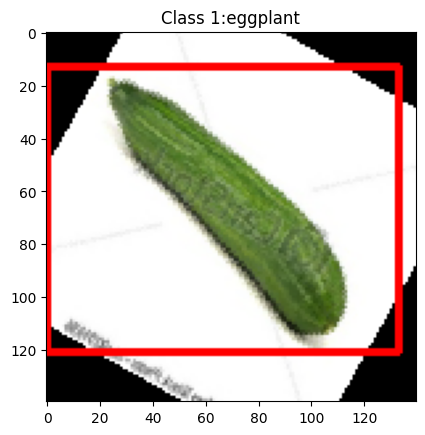

In [16]:
#Transforms 
trainset_tran=ObjLocDataset(train_df,transforms=train_trans)
validset_tran=ObjLocDataset(valid_df,transforms=valid_trans)

#trainset_tran = datasets.wrap_dataset_for_transforms_v2(trainset_tran)
#validset_tran = datasets.wrap_dataset_for_transforms_v2(validset_tran)

img, bbox, lbl = trainset_tran[12]

xmin, ymin, xmax, ymax = bbox[0]

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)
plt.title(f"Class {lbl}:{indx_to_class[lbl]}")
print(img.shape)

### 3. Albumentation Augmentation

torch.Size([3, 140, 140])


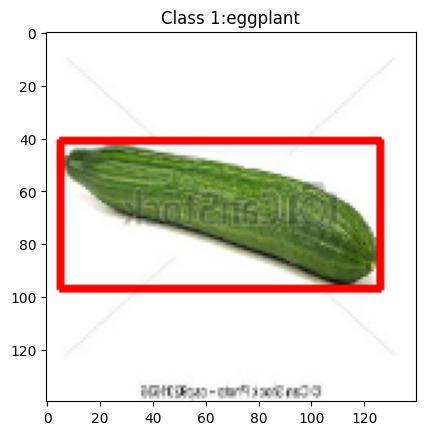

In [17]:
#Albumentation
trainset_aug=ObjLocDataset(train_df,aug=train_augs)
validset_aug=ObjLocDataset(valid_df,aug=valid_augs)

img, bbox, lbl = trainset_aug[12]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)
plt.title(f"Class {lbl}:{indx_to_class[lbl]}")
print(img.shape)

# Load dataset into batches

In [18]:
trainloader=torch.utils.data.DataLoader(trainset_aug,batch_size)
validloader=torch.utils.data.DataLoader(validset_aug,batch_size)

In [19]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [20]:
for images , bboxes,lbls in trainloader:
  break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))
print("Shape of one batch labels : {}".format(lbls.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])
Shape of one batch labels : torch.Size([16])


# Create Model

## Classification and Localization
- output of classification: Num classes(3)
- output of classification: Num points in bbox(4)

In [21]:
from torch import nn 
import timm

In [29]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.loc_model=  timm.create_model(model,pretrained=True,num_classes=4)
    self.class_model=timm.create_model(model,pretrained=True,num_classes=3)

  def forward(self,img,groundtruth_bbox=None,groundtruth_lbl=None):
    bbox=self.loc_model(img)
    lbl=self.class_model(img)

    if groundtruth_bbox!=None and groundtruth_lbl!=None:
      loc_loss=  nn.MSELoss()(bbox,groundtruth_bbox)
      class_loss=nn.CrossEntropyLoss()(lbl,groundtruth_lbl)
      loss=loc_loss+class_loss
      return bbox,lbl,loss

    return bbox,lbl

In [30]:
model_=ObjLocModel()
model_.to(device);

In [35]:
random_img=torch.rand(1,3,140,140).to(device)
loc_y,class_y=model_(random_img)
print("Classification output: ",class_y.shape,"\nLocalization output:   ",loc_y.shape)

Classification output:  torch.Size([1, 3]) 
Localization output:    torch.Size([1, 4])


# Create Train and Eval Function

In [43]:
def train_fn(model,dataloader,optimizer,current_epo):

  model.train()
  total_loss=0.0
  tk=tqdm( dataloader,desc=("Epoch"+"[Train]"+str(current_epo+1)+"/"+str(epochs)) )


  for t,data in enumerate(tk):
    images,bboxes,labels=data
    images, bboxes, labels=images.to(device) ,bboxes.to(device),labels.to(device)

    optimizer.zero_grad()
    bboxs_logits,labels_logits,loss=model(images,bboxes, labels)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
    tk.set_postfix({"loss": "%6f" %float(total_loss/(t+1))})

  return total_loss/len(dataloader)

In [44]:
def eval_fn(model,dataloader,current_epo):

  model.eval()
  total_loss=0.0
  tk=tqdm( dataloader,desc=("Epoch"+"[Valid]"+str(current_epo+1)+"/"+str(epochs)) )


  with torch.no_grad():
    for t,data in enumerate(tk):
      images,bboxes,labels=data
      images, bboxes, labels=images.to(device) ,bboxes.to(device),labels.to(device)

      bboxs_logits,labels_logits,loss=model(images,bboxes, labels)

      total_loss+=loss.item()
      tk.set_postfix({"loss": "%6f" %float(total_loss/(t+1))})

  return total_loss/len(dataloader)

#Training Loop

In [40]:
optimizer=torch.optim.Adam(model_.parameters(),lr=lr)

In [48]:
best_valid_loss=np.Inf
for i in range(epochs):
  train_loss =train_fn(model_, trainloader, optimizer, i)
  valid_loss =eval_fn (model_, validloader,            i) 

  if valid_loss <best_valid_loss:
    torch.save(model_.state_dict(),"best_weights.pt")
    print('best weights saved')
    best_valid_loss=valid_loss

Epoch[Train]1/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]1/40:   0%|          | 0/3 [00:00<?, ?it/s]

best weights saved


Epoch[Train]2/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]2/40:   0%|          | 0/3 [00:00<?, ?it/s]

best weights saved


Epoch[Train]3/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]3/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]4/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]4/40:   0%|          | 0/3 [00:00<?, ?it/s]

best weights saved


Epoch[Train]5/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]5/40:   0%|          | 0/3 [00:00<?, ?it/s]

best weights saved


Epoch[Train]6/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]6/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]7/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]7/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]8/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]8/40:   0%|          | 0/3 [00:00<?, ?it/s]

best weights saved


Epoch[Train]9/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]9/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]10/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]10/40:   0%|          | 0/3 [00:00<?, ?it/s]

best weights saved


Epoch[Train]11/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]11/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]12/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]12/40:   0%|          | 0/3 [00:00<?, ?it/s]

best weights saved


Epoch[Train]13/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]13/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]14/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]14/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]15/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]15/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]16/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]16/40:   0%|          | 0/3 [00:00<?, ?it/s]

best weights saved


Epoch[Train]17/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]17/40:   0%|          | 0/3 [00:00<?, ?it/s]

best weights saved


Epoch[Train]18/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]18/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]19/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]19/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]20/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]20/40:   0%|          | 0/3 [00:00<?, ?it/s]

best weights saved


Epoch[Train]21/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]21/40:   0%|          | 0/3 [00:00<?, ?it/s]

best weights saved


Epoch[Train]22/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]22/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]23/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]23/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]24/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]24/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]25/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]25/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]26/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]26/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]27/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]27/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]28/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]28/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]29/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]29/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]30/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]30/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]31/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]31/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]32/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]32/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]33/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]33/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]34/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]34/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]35/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]35/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]36/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]36/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]37/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]37/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]38/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]38/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]39/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]39/40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch[Train]40/40:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch[Valid]40/40:   0%|          | 0/3 [00:00<?, ?it/s]

best weights saved


#Inference

In [51]:
import cv2
import numpy
import torch 

import matplotlib.pyplot as plt 

def compare_plots(image, gt_bbox, out_bbox,gt_lbl,out_lbl):

    xmin, ymin, xmax, ymax = gt_bbox

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]

    out_pt1 = (int(out_xmin), int(out_ymin))
    out_pt2 = (int(out_xmax), int(out_ymax))

    out_img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(),pt1, pt2,(0,255,0),2)
    out_img = cv2.rectangle(out_img,out_pt1, out_pt2,(255,0,0),2)
    plt.imshow(out_img)
    plt.title(f"Groundtruth Label: {gt_lbl}: {indx_to_class[gt_lbl]}\npredicted Label:{out_lbl}: {indx_to_class[out_lbl]}")


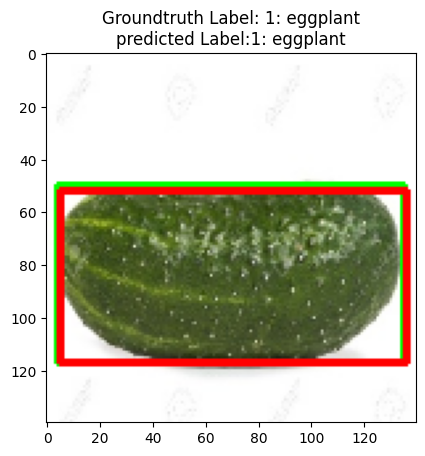

In [80]:
model_.load_state_dict(torch.load('/content/best_weights.pt'))
model_.eval()

with torch.no_grad():
  image,gt_bbox,gt_lbl=validset_aug[3]
  image=image.unsqueeze(0).to(device)
  out_bbox,out_lbl=model_(image)
  out_lbl=torch.argmax(nn.functional.softmax(out_lbl,dim=1))
  out_lbl=(out_lbl.cpu().detach().numpy().flatten().item())
  #print(out_lbl)
  #print(indx_to_class[out_lbl])
  compare_plots(image, gt_bbox, out_bbox,gt_lbl,out_lbl)
  

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya